<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert2-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers --quiet
!pip install wget --quiet

# Create Dataset

In [2]:
import torch
from torch.utils.data import Dataset
class ToxicDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

# Returns a dictionary containing the encoded sequence or sequence pair
# and additional information: the mask for sequence classification 
# and the overflowing elements if a max_length is specified.
    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

# Print metrics

In [3]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [4]:
from IPython.display import display
import pandas as pd

def print_stistics(training_stats,head=5):
        # Display floats with two decimal places.
        pd.set_option('display.precision', 2)

        # Create a DataFrame from our training statistics.
        df_stats = pd.DataFrame(data=training_stats)

        # Use the 'epoch' as the row index.
        df_stats = df_stats.set_index('epoch')

        # A hack to force the column headers to wrap.
        #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

        # Display the table.
        display(df_stats)

**Метрики**
precision, recall, accuracy, f1



In [5]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
def print_metrics(labels, predictions):
    
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
  print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
  print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions))) 
  print(classification_report(labels, predictions,digits=4))

**Матрица ошибок**

In [6]:
# from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
#   print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
#   print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
#   print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
#   print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions))) 
  print_metrics(labels, predictions)
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  plt.show()

**ROC - кривая**

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


def plot_roc(y_test,predictions_test):
#   print('рассчитываем ROC AUC')
#   print(predictions_test)
#   print("y_test")
#   print(y_test)
  # рассчитываем ROC AUC
  lr_auc = roc_auc_score(y_test, predictions_test)
  print(': ROC AUC=%.3f' % (lr_auc))
  # рассчитываем roc-кривую
  fpr, tpr, treshold = roc_curve(y_test, predictions_test)
  roc_auc = auc(fpr, tpr)
  # строим график

  # размеры шрифта
  SMALL_SIZE = 10
  MEDIUM_SIZE = 14
  BIGGER_SIZE = 16

  plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  plt.plot(fpr, tpr, color='darkorange',
          label='ROC кривая (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC-кривая')
  plt.legend(loc="lower right",)
  plt.show()

In [8]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot_train(training_stats):
        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        df_stats = pd.DataFrame(data=training_stats)

        # Use the 'epoch' as the row index.
        df_stats = df_stats.set_index('epoch')

        # Plot the learning curve.
        plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
        plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

        # Label the plot.
        plt.title("Training & Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.xticks([1, 2, 3, 4,5])

        plt.show()

# Bert fine-tune

In [9]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=5, model_save_path='./trainer',max_len=64):
            self.model = BertForSequenceClassification.from_pretrained(model_path)
            self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.model_save_path=model_save_path
            self.max_len = max_len
            self.epochs = epochs
            self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
            self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
            self.model.to(self.device)

    def preparation(self, X_train, y_train, X_valid, y_valid,X_test,y_test,batch_size = 32):
        
        # Create the DataLoader for Training set
        self.train_set = ToxicDataset(X_train, y_train, self.tokenizer,max_len=self.max_len)
        self.train_loader = DataLoader(self.train_set, batch_size=batch_size, shuffle=True)

        # Create the DataLoader for Val set
        self.valid_set = ToxicDataset(X_valid, y_valid, self.tokenizer,max_len=self.max_len)
        self.valid_loader = DataLoader(self.valid_set, batch_size= batch_size, shuffle=True)

        # Create the DataLoader for Test set
        self.test_set = ToxicDataset(X_test, y_test, self.tokenizer,max_len=self.max_len)
        self.test_loader = DataLoader(self.test_set, batch_size= batch_size, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
    
    def fit(self):

        t0 = time.time()

        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        print("")
        print("  Average training loss: {0:.2f}".format(train_loss))
        print("  Acc training: {0:.2f}".format(train_acc))
        print("  Training epcoh took: {:}".format(training_time))

        return train_acc, train_loss

    def eval(self):
        
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0
        all_logits = []
        all_targets = []
        with torch.no_grad():
            for batch in self.valid_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                targets = batch["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )
                
                all_logits.append(outputs.logits)
                all_targets.append(targets)

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        # print('all_targets')
        # print(all_targets)
        # print('all_logits')
        # print(all_logits)
        all_targets= torch.cat(all_targets, dim=0).cpu().numpy()
        all_logits = torch.cat(all_logits, dim=0)
        # print('torch.cat(all_logits, dim=0)')
        # print(all_logits)
        probs = torch.argmax(all_logits, dim=1).cpu().numpy()
        # print(probs)
        # print('probs')
        print()
        print('VALID:')
        print()
        print_metrics(all_targets, probs)
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss

    def train(self):
        training_stats = []
        best_accuracy = 0

        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

            ##### save statistics

            training_stats.append(
                {
                    'epoch': (epoch+ 1)*1,
                    'Training Loss': train_loss*1.0,
                    'Valid. Loss': val_loss*1.0,
                    'Training Accur': train_acc.item(),
                    'Valid. Accur.': val_acc.item(),
                }
            )

        print_stistics(training_stats)
        plot_train(training_stats)
        self.model = torch.load(self.model_save_path)
    
    def test(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0
        all_logits = []
        all_targets = []
        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                targets = batch["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )
                
                # _debug(outputs) # debug print 

                all_logits.append(outputs.logits)
                all_targets.append(targets)

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        # print('all_logits')
        # print(all_logits)
        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0).cpu().numpy()
        # print('После torch.cat(all_logits, dim=0)')
        # print(all_logits)
        probs = F.softmax(all_logits, dim=1).cpu().numpy()
        # print('probs')
        # print(probs)
        print('TEST:')
        print()
        threshold=0.5
        _preds = np.where(probs[:, 1] <threshold,0,1)
        plot_cm(all_targets, _preds)
        plot_roc(all_targets, probs[:, 1])
        
        val_acc = correct_predictions.double() / len(self.test_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss


    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction


УДАЛИТЬ -> отладка

In [10]:
def _debug(outputs):
    print('outputs')
    print(outputs)
    print()
    print('outputs.logits')
    print(outputs.logits)
    print()
    print('torch.argmax(outputs.logits, dim=1).cpu().numpy()')
    print(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    print()
    print('torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]')
    print(torch.argmax(outputs.logits, dim=1).cpu().numpy()[0])
    ii=100
    print('F.softmax(outputs.logits, dim=1).cpu().numpy()')
    print(F.softmax(outputs.logits, dim=1).cpu().numpy())
    print()
    print('label=1,F.softmax(outputs.logits, dim=1).cpu().numpy()[0][1]')
    print(F.softmax(outputs.logits, dim=1).cpu().numpy()[0][1])
    print()
    print('F.sigmoid(outputs.logits).cpu().numpy()')
    print(F.sigmoid(outputs.logits).cpu().numpy())
    print()
    print('np.max(F.softmax(outputs.logits, dim=1).cpu().numpy()[0])')
    print(np.max(F.softmax(outputs.logits, dim=1).cpu().numpy()[0]))
    # raise ValueError("Real error")
    print('prediction')

# Train, Eval, Test

**Load dataset**

In [11]:
import wget
import os
# PATH_CLEANED_DATASET='data_original_RU_2ch.csv'
PATH_CLEANED_DATASET='data_original_RU_merge_2ch_and_ok.csv'

url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET


if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Split dataset**

In [12]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values
print(len(sentences))
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

262702
(210161,)
(26270,)
(26271,)


Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

Epoch 1/3


100%|██████████| 6568/6568 [03:41<00:00, 29.65it/s]



  Average training loss: 0.13
  Acc training: 0.95
  Training epcoh took: 0:03:42
Train loss 0.13435990829144812 accuracy 0.9495244122363331

VALID:

Accuracy: 96.56 %
Recall: 92.17 %
Precision: 89.88 %
F1-score: 91.01 % 

              precision    recall  f1-score   support

           0     0.9816    0.9758    0.9787     21306
           1     0.8988    0.9217    0.9101      4965

    accuracy                         0.9656     26271
   macro avg     0.9402    0.9487    0.9444     26271
weighted avg     0.9660    0.9656    0.9658     26271

Val loss 0.09728557182913794 accuracy 0.9655894332153325
----------
Epoch 2/3


100%|██████████| 6568/6568 [03:42<00:00, 29.46it/s]



  Average training loss: 0.08
  Acc training: 0.97
  Training epcoh took: 0:03:43
Train loss 0.08495067560611531 accuracy 0.9711744805173177

VALID:

Accuracy: 97.07 %
Recall: 92.00 %
Precision: 92.43 %
F1-score: 92.22 % 

              precision    recall  f1-score   support

           0     0.9814    0.9824    0.9819     21306
           1     0.9243    0.9200    0.9222      4965

    accuracy                         0.9707     26271
   macro avg     0.9529    0.9512    0.9520     26271
weighted avg     0.9706    0.9707    0.9706     26271

Val loss 0.09035981361511482 accuracy 0.9706520497887404
----------
Epoch 3/3


100%|██████████| 6568/6568 [03:41<00:00, 29.66it/s]



  Average training loss: 0.07
  Acc training: 0.98
  Training epcoh took: 0:03:41
Train loss 0.07163095524933813 accuracy 0.9764466290129948

VALID:

Accuracy: 97.06 %
Recall: 91.78 %
Precision: 92.60 %
F1-score: 92.19 % 

              precision    recall  f1-score   support

           0     0.9809    0.9829    0.9819     21306
           1     0.9260    0.9178    0.9219      4965

    accuracy                         0.9706     26271
   macro avg     0.9535    0.9504    0.9519     26271
weighted avg     0.9705    0.9706    0.9706     26271

Val loss 0.094509239546046 accuracy 0.9706139850024742
----------


,Training Loss,Valid. Loss,Training Accur,Valid. Accur.
epoch,,,,
1,0.13,0.10,0.95,0.97
2,0.08,0.09,0.97,0.97
3,0.07,0.09,0.98,0.97


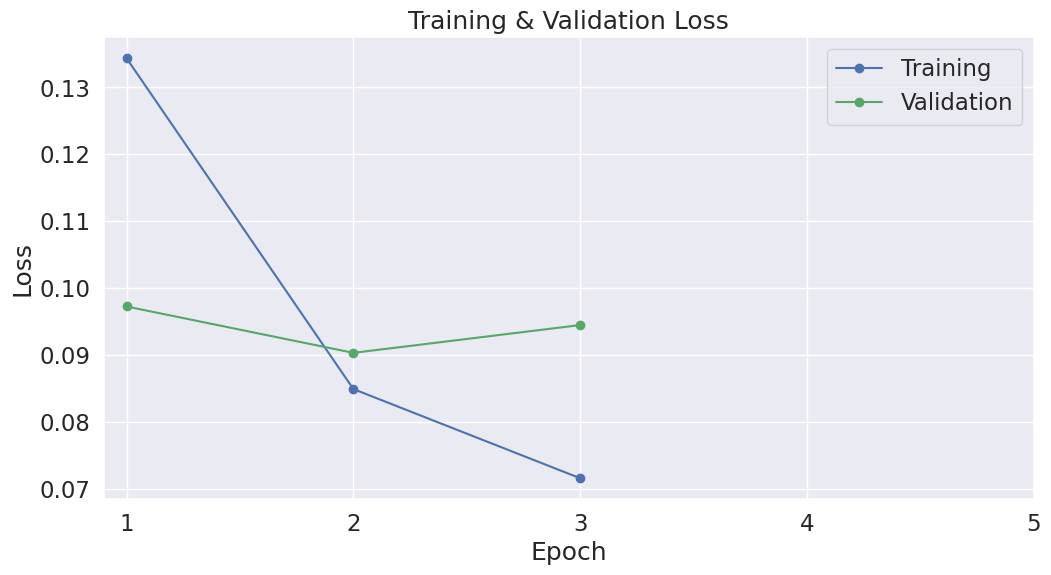

In [13]:
MODEL_PATH = 'cointegrated/rubert-tiny2'


classifier = BertClassifier(
        model_path=MODEL_PATH,
        tokenizer_path=MODEL_PATH,
        max_len=64,
        n_classes=2,
        epochs=3,
        model_save_path='./trainer'
)

classifier.preparation(
        X_train=X_train,
        y_train=y_train,
        X_valid=  X_val,
        y_valid=  y_val,
        X_test=  X_test,
        y_test=  y_test,
        batch_size=32
    )

classifier.train()

TEST:

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Accuracy: 96.99 %
Recall: 92.56 %
Precision: 91.83 %
F1-score: 92.20 % 

              precision    recall  f1-score   support

           0     0.9822    0.9804    0.9813     21216
           1     0.9183    0.9256    0.9220      5054

    accuracy                         0.9699     26270
   macro avg     0.9503    0.9530    0.9516     26270
weighted avg     0.9699    0.9699    0.9699     26270

True Negatives:  20800
False Positives:  416
False Negatives:  376
True Positives:  4678


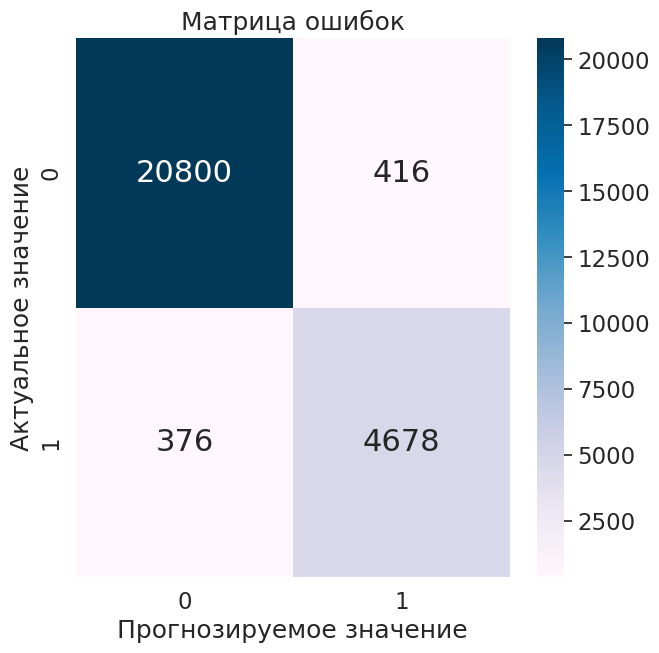

: ROC AUC=0.992


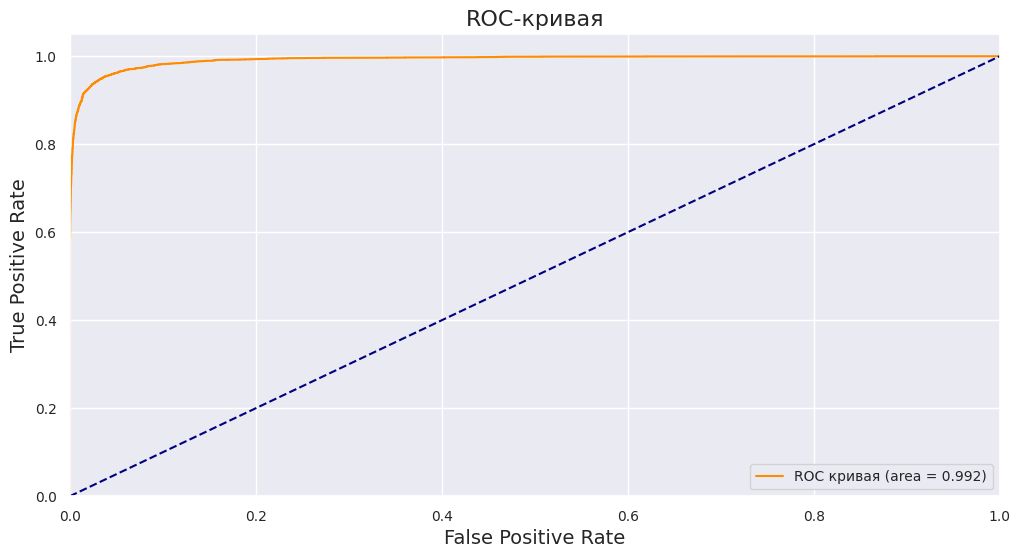

(tensor(0.9699, device='cuda:0', dtype=torch.float64), 0.09034474752573966)

In [14]:
classifier.test()

In [15]:
path = './trainer-for-transformers'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)

('./trainer-for-transformers/tokenizer_config.json',
 './trainer-for-transformers/special_tokens_map.json',
 './trainer-for-transformers/vocab.txt',
 './trainer-for-transformers/added_tokens.json')

In [16]:
AntiInterr=777+0

In [17]:
AntiInterr=777+0

In [ ]:
AntiInterr=777+0